In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

df_eswp = pd.read_csv("../../data/interim/alex/Evaporation_Sunshine_WindGustDir_WindGustSpeed_Pressure9am_Pressure3pm_WindGustDirNum.csv")
df = pd.read_csv("../../data/raw/weatherAUS.csv")


## 1. Vérification de la bonne création du csv: Les stations correspondent-elles?

In [2]:
# Vérification de la bonne création du csv:
df_eswp['Location'].unique()

array(['Newcastle'], dtype=object)

In [3]:
# Création du dictionnaire clé = station, valeurs = grandeurs non mesurées
dict = {}
for i in range(df['Location'].unique().shape[0]):  # df['Location'].unique().shape[0]: le nombre de stations
    measures = []
    non_measures = []
    station_df = df.loc[df['Location'] == df['Location'].unique()[i]] #création d'un df pour une station
    for col in station_df.columns:
        if station_df[col].isna().sum()/station_df.shape[0] != 1: # si le pourcentage de nan est différent de 1
            measures.append(col) # on ajoute la grandeur mesurée à 'measures
        else:
            non_measures.append(col) # sinon, on l'ajoute à 'non_measures'
    if non_measures == []:
        dict[df['Location'].unique()[i]] = ['all']
    else:
        dict[df['Location'].unique()[i]] = non_measures

### Liste des différentes modalités de non-mesures:
modalites = []
for station in dict:
    if dict[station] not in modalites:
        modalites.append(dict[station])

### Création du dictionnaire inverse: clé = liste concaténée des grandeurs non mesurées, valeurs = liste des stations correspondantes
dict_reverse = {}
for i, mod in zip(range(len(modalites)), modalites):
    liste_stations = []
    for station in dict:
        if dict[station] == mod:
            liste_stations.append(station)
    dict_reverse["_".join(modalites[i])] = liste_stations # J'ai appris qu'un dictionnaire ne peut pas prendre de liste en guise de clé. 
                                                          #J'ai décidé de concaténer le nom des colonnes non mesurées avec un "_"       
    #print(mod, ":", liste_stations) 

dict_reverse['Evaporation_Sunshine_WindGustDir_WindGustSpeed_Pressure9am_Pressure3pm']

['Newcastle']

## 2. Gestion des nan

In [4]:
# Reset df sur le tableau séparé
df = pd.read_csv("Evaporation_Sunshine_WindGustDir_WindGustSpeed_Pressure9am_Pressure3pm_WindGustDirNum.csv")

In [5]:
# Sélection des variables à remplacer par la moyenne
mean_var = ['MinTemp', 'MaxTemp',  'WindSpeed9am', 'WindSpeed3pm', 
            'Humidity9am', 'Humidity3pm', 'Cloud9am', 'Cloud3pm', 
            'Temp9am', 'Temp3pm', 
             'WindDir9amNum', 'WindDir3pmNum']
left_over = ['Rainfall']

#Sélection des variables catégorielles à remplacer par le mode:
mode_var =['WindDir9am', 'WindDir3pm'] # sléection des variables catégorielles à remplacer

In [6]:
# Remplacement des nan par la moyenne ou le mode le plus fréquent:

for station in df['Location'].unique():
    dict_mean_values = {} # Initialisation dictionnaire pour les valeurs moyennes des variables numériques
    dict_mode_values = {} # Initialisation dictionnaire pour les valeurs les plus fréquentes des variables catégorielles
    
    data = df.loc[df['Location'] == station].copy() # je n'ai pas trouvé d'autre solutions que celle ci, qui me parait un peu lourde niveau mémoire, puisqu'elle nécéssite de créer une copie pour chaque station. Mais je m'arête là car ça marche.
    
    for var in mean_var:   #Création du dictionnaire pour les valeurs moyennes des variables numériques
        if var == 'Cloud9am' or var == 'Cloud3pm':             # Test spécifique sur les Clouds pour arrondir la moyenne
            dict_mean_values[var] = round(data[var].mean(), 0)
        else:
            dict_mean_values[var] = data[var].mean()
    
    for var in mode_var:   #Création du dictionnaire pour les valeurs les plus fréquentes des variables catégorielles
        dict_mode_values[var] = data[var].mode()[0]
    
    data.fillna(value = dict_mean_values, inplace = True)
    data.fillna(value = dict_mode_values, inplace = True)
    df.fillna(data, inplace = True)

In [7]:
# Déja fait en préproc:
# Drop les NaN de la variable cible.
#df.dropna(subset = 'RainTomorrow', inplace = True)

# Drop les NaN de la variable RainToday.
#df.dropna(subset = 'RainToday', inplace = True)

In [8]:
# Vérification du taux de nan:
round(df.isna().sum()/df.shape[0] *100, 2)
# Les grandeurs sélectionnées sont à zéro: tout a bien fonctionné.

Unnamed: 0.1     0.0
Unnamed: 0       0.0
Date             0.0
Location         0.0
MinTemp          0.0
MaxTemp          0.0
Rainfall         0.0
WindDir9am       0.0
WindDir3pm       0.0
WindSpeed9am     0.0
WindSpeed3pm     0.0
Humidity9am      0.0
Humidity3pm      0.0
Cloud9am         0.0
Cloud3pm         0.0
Temp9am          0.0
Temp3pm          0.0
RainToday        0.0
RainTomorrow     0.0
year             0.0
month            0.0
day              0.0
LocationNum      0.0
WindDir9amNum    0.0
WindDir3pmNum    0.0
Latitude         0.0
Longitude        0.0
CodeRegion       0.0
NonMes           0.0
CodeRegionNum    0.0
NonMesNum        0.0
dtype: float64

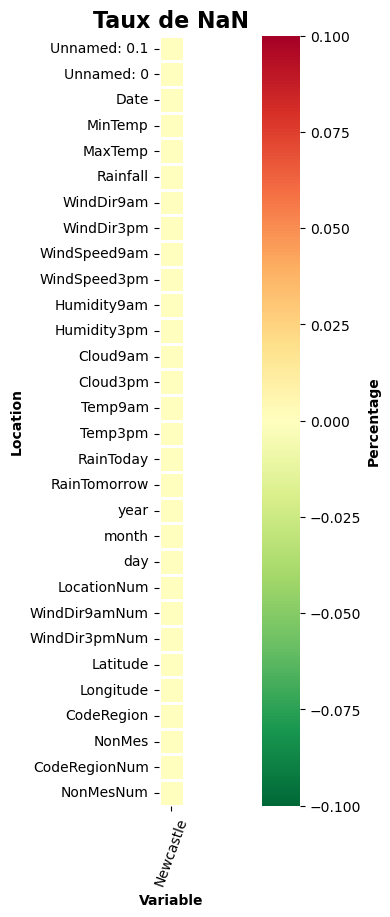

In [9]:
# On le vérifie sur la heatmap des nan:
def nan_rate_count(col):
    nr = round(col.isna().sum()/col.shape[0]*100, 2)
    return nr

nan_map = df.groupby('Location').agg(nan_rate_count)

plt.figure(figsize = (20,10))
ax = sns.heatmap(nan_map.T, annot = False, cmap = "RdYlGn_r", square = True, linewidth = 1, annot_kws={"size":6}, fmt=".0f", cbar_kws = {"label": "Percentage"})

## Mise en forme
plt.title("Taux de NaN", fontweight = "bold", fontsize = 16)
plt.xlabel("Variable", fontweight = "bold")
plt.ylabel("Location", fontweight = "bold")
plt.xticks(rotation = 70)
cbar_axes = ax.figure.axes[-1].yaxis.label.set_weight("bold")
plt.show()

In [12]:
# Préparation de la suppression des variables catégorielles:

# Mise au format datetime de la colonne 'Date':
df['Date'] = pd.to_datetime(df['Date'])

# Suppression des variables Unnamed
df.drop(columns = ['Unnamed: 0', 'Unnamed: 0.1'], inplace = True)

# Suppression des variables catégorielles:
drop_cat = df.select_dtypes(object).columns
df.drop(columns = drop_cat, inplace = True)

# Création du csv final prêt pour la modélisation
df.to_csv('ready_Evaporation_Sunshine_WindGustDir_WindGustSpeed_Pressure9am_Pressure3pm_WindGustDirNum.csv')